# Impacto de la Reducción de Dimensionalidad con SVD en la Clasificacion de Imágenes

# Tabla de Contenidos

- [Descripción](#Descripción)
- [Generación de los datasets con SVD](#Generación-de-los-datasets-con-SVD)
  - [Dataset SVD 64x64](#Generación-del-dataset-SVD-64x64)
  - [Dataset SVD 128x128](#Generación-del-dataset-SVD-128x128)
  - [Dataset SVD 64x64 ruidoso](#Generación-del-dataset-SVD-64x64-ruidoso)
  - [Dataset SVD 128x128 ruidoso](#Generación-del-dataset-SVD-128x128-ruidoso)
- [Entrenamiento de los modelos](#Entrenamiento-de-los-modelos)
  - [Dataset Chaoyang y el procesado por SVD](#Comparación-entre-el-Dataset-Chaoyang-y-el-procesado-por-SVD)
    - [Entrenamiento con Chaoyang](#Entrenamiento-con-el-Dataset-Chaoyang)
    - [Entrenamiento con SVD 64x64](#Entrenamiento-con-el-Dataset-Chaoyang-SVD-64x64)
    - [Entrenamiento con SVD 128x128](#Entrenamiento-con-el-Dataset-Chaoyang-SVD-128x128)
  - [Dataset Chaoyang y el procesado por SVD Modelo Preentrenado](#Comparación-entre-el-Dataset-Chaoyang-y-el-procesado-por-SVD-Modelo-Preentrenado)
    - [Entrenamiento con el Dataset Chaoyang Modelo Preentrenado](#Entrenamiento-con-el-Dataset-Chaoyang-Modelo-Preentrenado)
    - [Entrenamiento con SVD 64x64 Modelo Preentrenado](#Entrenamiento-con-el-Dataset-Chaoyang-SVD-64x64-Modelo-Preentrenado)
    - [Entrenamiento con SVD 128x128 Modelo Preentrenado](#Entrenamiento-con-el-Dataset-Chaoyang-SVD-128x128-Modelo-Preentrenado)
  - [Dataset Chaoyang y el procesado por SVD Ruidoso](#Comparación-entre-el-Dataset-Chaoyang-y-el-procesado-por-SVD-Ruidoso)
    - [Entrenamiento con el Dataset Chaoyang Ruidoso](#Entrenamiento-con-el-Dataset-Chaoyang-Ruidoso)
    - [Entrenamiento con SVD Ruidoso 64x64](#Entrenamiento-con-el-Dataset-Chaoyang-SVD-Ruidoso-64x64)
    - [Entrenamiento con SVD Ruidoso 128x128](#Entrenamiento-con-el-Dataset-Chaoyang-SVD-Ruidoso-128x128)

- [Comparacion Total](#Comparacion-Total)
    - [Plots Dataset Chaoyang y SVD](#Plots-comparación-entre-Dataset-Chaoyang-y-SVD)
    - [Plots Dataset Chaoyang y SVD en el tiempo](#Plots-comparación-entre-Dataset-Chaoyang-y-SVD-en-el-tiempo)
    - [Plots Dataset Chaoyang y SVD Modelo Preentrenado](#Plots-comparación-entre-Dataset-Chaoyang-y-SVD-Modelo-Preentrenado)
    - [Plots Dataset Chaoyang y SVD en el tiempo Modelo Preentrenado](#Plots-comparación-entre-Dataset-Chaoyang-y-SVD-en-el-tiempo-Modelo-Preentrenado)
    - [Plots Dataset Chaoyang y SVD con ruido](#Plots-comparación-entre-Dataset-Chaoyang-y-SVD-con-ruido)
    - [Plots Dataset Chaoyang y SVD  con ruido en el tiempo](#Plots-comparación-entre-Dataset-Chaoyang-y-SVD-con-ruido-en-el-tiempo)
  - [Tablas](#Tablas)
- [Conclusiones](#Conclusiones)  


# Descripción

Se investiga el impacto de la reducción de dimensionalidad y la introducción de ruido en el procesamiento y clasificación de imágenes utilizando el dataset Chaoyang de enfermedades de colon. Se genera una serie de datasets con diferentes resoluciones y niveles de ruido mediante la aplicación de Descomposición en Valores Singulares (SVD).

Para ello, se crean datasets con resoluciones de 64x64 y 128x128 píxeles, tanto en su forma original como con la adición de ruido. El rendimiento de estos datasets se evalúa utilizando un modelo ResNet34 en dos escenarios: desde cero y preentrenado, estos se comparan los tiempos de procesamiento y la precisión de los modelos entrenados con el dataset original y los datasets procesados por SVD. 

Los resultados se presentan en plots comparativos y en tablas, para una evaluación detallada del rendimiento de los modelos.

# Generación de los datasets con SVD

La reducción de dimensionalidad de las imágenes se realiza utilizando SVD. La SVD descompone una matriz en tres matrices: $U$, $S$, y $V^T$. El procedimiento se describe a continuación junto con el código que implementa esta técnica.

Dada una imagen representada por una matriz $A$, la SVD descompone $A$ en:
$$
A = U \Sigma V^T
$$
donde:
- $U$ es una matriz ortogonal que contiene los vectores singulares izquierdos.
- $\Sigma$ es una matriz diagonal que contiene los valores singulares.
- $V^T$ es la transpuesta de una matriz ortogonal que contiene los vectores singulares derechos.

Para reducir la dimensionalidad de la imagen, seleccionamos los primeros $k$ valores singulares, reduciendo las matrices $U$, $\Sigma$, y $V^T$ a las primeras $k$ columnas o filas:

$$
A_k = U_k \Sigma_k V_k^T
$$

Beneficios de la reducción de dimensionalidad al aplicar SVD al Dataset:

1. **Mejora en el Tiempo de Procesamiento**:
   - Al reducir la dimensionalidad de las imágenes, se disminuye la cantidad de datos que el modelo necesita procesar. Esto resulta en tiempos de entrenamiento y predicción más rápidos, ya que el modelo trabaja con matrices más pequeñas y menos complejas.
   - Por ejemplo, al reducir una imagen de $512 \times 512$ píxeles a $64 \times 64$ píxeles, se reduce drásticamente la cantidad de píxeles que el modelo debe analizar, lo que acelera el procesamiento.

2. **Eliminación de Ruido**:
   - SVD permite captar las componentes principales de la imagen y descartar las menores, que a menudo representan ruido o detalles menos importantes. Esto ayuda a mejorar la calidad de los datos de entrada, facilitando que el modelo se enfoque en las características más relevantes.
   - Al retener solo los primeros $k$ valores singulares, se eliminan las valores que pueden no ser importantes para la tarea de clasificación, mejorando potencialmente el rendimiento del modelo.


## Generación del dataset SVD 64x64
Se genera un dataset con resolución de 64x64 píxeles utilizando SVD a partir del dataset original de Chaoyang de 512x512 píxeles.

In [1]:
import json
import os
import numpy as np
from PIL import Image

def reduce_image_svd(image, target_size):
    image = np.array(image)
    reduced_image = np.zeros((target_size, target_size, 3), dtype=np.uint8)
    
    for channel in range(3):
        U, S, Vt = np.linalg.svd(image[:, :, channel], full_matrices=False)
        k = target_size
        U_k = U[:, :k]
        S_k = np.diag(S[:k])
        Vt_k = Vt[:k, :]
        reduced_channel = np.dot(U_k, np.dot(S_k, Vt_k))  
        reduced_channel = Image.fromarray(reduced_channel).resize((target_size, target_size), Image.BICUBIC)
        reduced_image[:, :, channel] = np.array(reduced_channel)

    return Image.fromarray(reduced_image)

def create_svd_dataset(json_file, img_dir, output_dir, target_size):
    with open(json_file, 'r') as f:
        data_info = json.load(f)

    os.makedirs(output_dir, exist_ok=True)
    for item in data_info:
        img_path = os.path.join(img_dir, item['name'])
        image = Image.open(img_path).convert("RGB")
        image = image.resize((512, 512))
        reduced_image = reduce_image_svd(image, target_size)
        
        reduced_image_path = os.path.join(output_dir, item['name'])
        os.makedirs(os.path.dirname(reduced_image_path), exist_ok=True)
        reduced_image.save(reduced_image_path)

    new_json_file = os.path.join(output_dir, os.path.basename(json_file))
    with open(new_json_file, 'w') as f:
        json.dump(data_info, f)

train_json = './datasets/chaoyang/train.json'
test_json = './datasets/chaoyang/test.json'
img_dir = './datasets/chaoyang'
output_dir = './datasets/chaoyang_svd'
target_size = 64

create_svd_dataset(train_json, img_dir, os.path.join(output_dir, 'train'), target_size)
create_svd_dataset(test_json, img_dir, os.path.join(output_dir, 'test'), target_size)

print("Dataset creado.")

Dataset creado.


## Generación del dataset SVD 128x128
Se genera un dataset con resolución de 128x128 píxeles utilizando SVD a partir del dataset original de Chaoyang 512x512 píxeles.

In [2]:
import json
import os
import numpy as np
from PIL import Image

train_json = './datasets/chaoyang/train.json'
test_json = './datasets/chaoyang/test.json'
img_dir = './datasets/chaoyang'
output_dir = './datasets/chaoyang_svd_128'
target_size = 128

create_svd_dataset(train_json, img_dir, os.path.join(output_dir, 'train'), target_size)
create_svd_dataset(test_json, img_dir, os.path.join(output_dir, 'test'), target_size)

print("Dataset creado.")

Dataset creado.


## Generación del dataset SVD 64x64 ruidoso
Se introduce ruido al dataset original de Chaoyang y luego se aplica SVD para obtener un dataset con resolución de 64x64 píxeles.

In [5]:
import json
import os
import numpy as np
from PIL import Image

def add_noise(image, noise_level=0.2):
    np_image = np.array(image)
    noise = np.random.normal(0, noise_level*255, np_image.shape)
    noisy_image = np.clip(np_image + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_image)

def create_dataset(json_file, img_dir, noisy_output_dir, svd_output_dir, noise_level, target_size):
    with open(json_file, 'r') as f:
        data_info = json.load(f)

    os.makedirs(noisy_output_dir, exist_ok=True)
    os.makedirs(svd_output_dir, exist_ok=True)
    for item in data_info:
        img_path = os.path.join(img_dir, item['name'])
        image = Image.open(img_path).convert("RGB")
        image = image.resize((512, 512))

        noisy_image = add_noise(image, noise_level)
        noisy_image_path = os.path.join(noisy_output_dir, item['name'])
        os.makedirs(os.path.dirname(noisy_image_path), exist_ok=True)
        noisy_image.save(noisy_image_path)

        reduced_image = reduce_image_svd(noisy_image, target_size)
        reduced_image_path = os.path.join(svd_output_dir, item['name'])
        os.makedirs(os.path.dirname(reduced_image_path), exist_ok=True)
        reduced_image.save(reduced_image_path)

    new_json_file_noisy = os.path.join(noisy_output_dir, os.path.basename(json_file))
    new_json_file_svd = os.path.join(svd_output_dir, os.path.basename(json_file))
    with open(new_json_file_noisy, 'w') as f:
        json.dump(data_info, f)
    with open(new_json_file_svd, 'w') as f:
        json.dump(data_info, f)

train_json = './datasets/chaoyang/train.json'
test_json = './datasets/chaoyang/test.json'
img_dir = './datasets/chaoyang'
noisy_output_dir_train = './datasets/chaoyang_noisy/train'
noisy_output_dir_test = './datasets/chaoyang_noisy/test'
svd_output_dir_train = './datasets/chaoyang_noisy_svd/train'
svd_output_dir_test = './datasets/chaoyang_noisy_svd/test'
noise_level = 0.5
target_size = 64

create_dataset(train_json, img_dir, noisy_output_dir_train, svd_output_dir_train, noise_level, target_size)
create_dataset(test_json, img_dir, noisy_output_dir_test, svd_output_dir_test, noise_level, target_size)

print("Dataset ruido creado.")


Dataset ruido creado.


## Generación del dataset SVD 128x128 ruidoso
Se introduce ruido al dataset original de Chaoyang y luego se aplica SVD para obtener un dataset con resolución de 128x128 píxeles.

In [6]:
import json
import os
import numpy as np
from PIL import Image

train_json = './datasets/chaoyang/train.json'
test_json = './datasets/chaoyang/test.json'
img_dir = './datasets/chaoyang'
noisy_output_dir_train = './datasets/chaoyang_noisy/train'
noisy_output_dir_test = './datasets/chaoyang_noisy/test'
svd_output_dir_train = './datasets/chaoyang_noisy_svd/train'
svd_output_dir_test = './datasets/chaoyang_noisy_svd/test'
noise_level = 0.5
target_size = 128

create_dataset(train_json, img_dir, noisy_output_dir_train, svd_output_dir_train, noise_level, target_size)
create_dataset(test_json, img_dir, noisy_output_dir_test, svd_output_dir_test, noise_level, target_size)

print("Dataset ruido creado.")

Dataset ruido creado.


# Entrenamiento de los modelos

Se incluye múltiples entrenamientos de modelos utilizando el dataset Chaoyang y su versión procesada mediante SVD. Primero, se entrena el modelo con el dataset Chaoyang original, proporcionando una referencia para comparar el rendimiento. Luego, se entrena el modelo con versiones reducidas del dataset a resoluciones de 64x64 y 128x128 píxeles mediante SVD para evaluar el impacto de la reducción de dimensionalidad. 

Además, se entrena un modelo preentrenado con el dataset Chaoyang original y sus versiones reducidas, observando cómo el conocimiento previo del modelo mejora el rendimiento. 

También se investiga el efecto del ruido entrenando el modelo con el dataset Chaoyang al que se le ha añadido ruido, y sus versiones reducidas a 64x64 y 128x128 píxeles mediante SVD. 

Estos entrenamientos permiten analizar cómo la reducción de dimensionalidad, el uso de modelos preentrenados y la adición de ruido afectan el rendimiento y la eficiencia del modelo.


## Comparación entre el Dataset Chaoyang y el procesado por SVD

### Entrenamiento con el Dataset Chaoyang
Se entrena un modelo ResNet34 desde cero utilizando el dataset original de Chaoyang 512x512 píxeles.

In [29]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from torchvision.transforms.functional import to_tensor
import time

custom_mean = [0.6470, 0.5523, 0.6695]
custom_std = [0.1698, 0.1994, 0.1284]

class ImageDataset(Dataset):
    def __init__(self, json_file, img_dir, transform=None):
        with open(json_file, 'r') as f:
            self.data_info = json.load(f)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_info)

    def __getitem__(self, idx):
        img_path = f'{self.img_dir}/{self.data_info[idx]["name"]}'
        image = Image.open(img_path).convert("RGB")
        image = to_tensor(image)
        label = self.data_info[idx]['label']
        if self.transform:
            image = self.transform(image)
        return image, label

original_train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Normalize(mean=custom_mean, std=custom_std),
])

original_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=custom_mean, std=custom_std),
])

svd_train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Normalize(mean=custom_mean, std=custom_std),
])

svd_test_transform = transforms.Compose([
    transforms.Normalize(mean=custom_mean, std=custom_std),
])

def load_datasets(dataset_type):
    train_json = f'./datasets/{dataset_type}/train.json'
    test_json = f'./datasets/{dataset_type}/test.json'
    img_dir = f'./datasets/{dataset_type}'
    
    if dataset_type == 'chaoyang':
        train_transform = original_train_transform
        test_transform = original_test_transform
    else:
        train_transform = svd_train_transform
        test_transform = svd_test_transform
    
    train_dataset = ImageDataset(train_json, img_dir, transform=train_transform)
    test_dataset = ImageDataset(test_json, img_dir, transform=test_transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    return train_loader, test_loader

model = models.resnet34(weights=None)
num_ftrs = model.fc.in_features
num_classes = 4  
model.fc = nn.Linear(num_ftrs, num_classes) 

initial_weights = model.state_dict()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()

def evaluate_model(model, loader, criterion):
    model.eval()
    loss_total, correct_total = 0.0, 0
    confusion_matrix = torch.zeros(4, 4, dtype=torch.int64)
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_total += loss.item()
            _, predictions = torch.max(outputs, 1)
            correct_total += (predictions == labels).sum().item()
            for t, p in zip(labels.view(-1), predictions.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    accuracy = 100.0 * correct_total / len(loader.dataset)
    sensitivity = confusion_matrix.diag() / confusion_matrix.sum(1)
    return loss_total / len(loader), accuracy, sensitivity.tolist(), confusion_matrix.tolist()

def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=50):
    stats = {
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': [],
        'sensitivity': [],
        'confusion_matrix': [],
        'epoch_times': []
    }

    initial_train_loss, initial_train_accuracy, _, _ = evaluate_model(model, train_loader, criterion)
    stats['train_loss'].append(initial_train_loss)
    stats['train_accuracy'].append(initial_train_accuracy)

    initial_test_loss, initial_test_accuracy, initial_sensitivity, initial_conf_matrix = evaluate_model(model, test_loader, criterion)
    stats['test_loss'].append(initial_test_loss)
    stats['test_accuracy'].append(initial_test_accuracy)
    stats['sensitivity'].append(initial_sensitivity)
    stats['confusion_matrix'].append(initial_conf_matrix)
    
    print(f'Initial Train Loss: {initial_train_loss:.4f}, Initial Train Accuracy: {initial_train_accuracy:.2f}%')
    print(f'Initial Test Loss: {initial_test_loss:.4f}, Initial Test Accuracy: {initial_test_accuracy:.2f}%')

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

        if scheduler is not None:
            scheduler.step()

        train_accuracy = 100.0 * train_correct / train_total
        stats['train_loss'].append(train_loss / len(train_loader))
        stats['train_accuracy'].append(train_accuracy)

        test_loss, test_accuracy, sensitivity, conf_matrix = evaluate_model(model, test_loader, criterion)
        stats['test_loss'].append(test_loss)
        stats['test_accuracy'].append(test_accuracy)
        stats['sensitivity'].append(sensitivity)
        stats['confusion_matrix'].append(conf_matrix)

        epoch_duration = time.time() - start_time
        stats['epoch_times'].append(epoch_duration)
        
        print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, '
              f'Time: {epoch_duration:.2f}s, Sensitivity: {sensitivity}')

    return stats

datasets = ['chaoyang', 'chaoyang_svd']
learning_rate = 1e-4
weight_decay = 5e-4

for dataset in datasets:
    print(f'Dataset: {dataset}, Learning Rate: {learning_rate}, Weight Decay: {weight_decay}')
    print("\n")
    model.load_state_dict(initial_weights) 
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
    train_loader, test_loader = load_datasets(dataset)
    stats = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler)

    filename = f'resnet34_{dataset}_{learning_rate}_{weight_decay}.json'
    with open(filename, 'w') as f:
        json.dump(stats, f)
    print(f'Saved stats to {filename}')
    print("\n")


Dataset: chaoyang, Learning Rate: 0.0001, Weight Decay: 0.0005


Initial Train Loss: 45.9069, Initial Train Accuracy: 20.94%
Initial Test Loss: 52.6355, Initial Test Accuracy: 15.01%
Epoch 1/50: Train Loss: 1.2611, Train Accuracy: 44.12%, Test Loss: 1.1031, Test Accuracy: 53.81%, Time: 42.82s, Sensitivity: [0.5858156085014343, 0.07165109366178513, 0.8190476298332214, 0.09890110045671463]
Epoch 2/50: Train Loss: 1.2020, Train Accuracy: 48.30%, Test Loss: 1.0729, Test Accuracy: 56.29%, Time: 38.60s, Sensitivity: [0.5602836608886719, 0.0, 0.738095223903656, 0.692307710647583]
Epoch 3/50: Train Loss: 1.1530, Train Accuracy: 51.53%, Test Loss: 1.0003, Test Accuracy: 61.94%, Time: 45.17s, Sensitivity: [0.568794310092926, 0.018691588193178177, 0.9357143044471741, 0.48351648449897766]
Epoch 4/50: Train Loss: 1.0565, Train Accuracy: 55.73%, Test Loss: 0.9414, Test Accuracy: 60.54%, Time: 40.55s, Sensitivity: [0.6709219813346863, 0.25233644247055054, 0.8785714507102966, 0.010989011265337467]
Epo

### Entrenamiento con el Dataset Chaoyang SVD 64x64
Se entrena un modelo ResNet34 desde cero utilizando el dataset reducido por SVD a 64x64 píxeles.

In [31]:
import json
impor1t torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from torchvision.transforms.functional import to_tensor
import time

model = models.resnet34(weights=None)
num_ftrs = model.fc.in_features
num_classes = 4  
model.fc = nn.Linear(num_ftrs, num_classes) 

initial_weights = model.state_dict()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()

datasets = ['chaoyang_svd']
learning_rate = 1e-3
weight_decay = 5e-4

for dataset in datasets:
    print(f'Dataset: {dataset}, Learning Rate: {learning_rate}, Weight Decay: {weight_decay}')
    print("\n")
    model.load_state_dict(initial_weights) 
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
    train_loader, test_loader = load_datasets(dataset)
    stats = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler)

    filename = f'resnet34_{dataset}_{learning_rate}_{weight_decay}.json'
    with open(filename, 'w') as f:
        json.dump(stats, f)
    print(f'Saved stats to {filename}')
    print("\n")


Dataset: chaoyang_svd, Learning Rate: 0.001, Weight Decay: 0.0005


Initial Train Loss: 7.6020, Initial Train Accuracy: 27.63%
Initial Test Loss: 6.6957, Initial Test Accuracy: 32.96%
Epoch 1/50: Train Loss: 1.4401, Train Accuracy: 37.78%, Test Loss: 3.1026, Test Accuracy: 17.34%, Time: 6.78s, Sensitivity: [0.0, 0.42990654706954956, 0.0, 0.8534798622131348]
Epoch 2/50: Train Loss: 1.2323, Train Accuracy: 46.33%, Test Loss: 1.4448, Test Accuracy: 38.80%, Time: 4.83s, Sensitivity: [0.3645389974117279, 0.19314642250537872, 0.37857142090797424, 0.7069597244262695]
Epoch 3/50: Train Loss: 1.1559, Train Accuracy: 49.84%, Test Loss: 1.1781, Test Accuracy: 42.31%, Time: 4.82s, Sensitivity: [0.7517730593681335, 0.41744548082351685, 0.2857142984867096, 0.0036630036775022745]
Epoch 4/50: Train Loss: 1.1178, Train Accuracy: 51.16%, Test Loss: 1.0515, Test Accuracy: 55.59%, Time: 6.95s, Sensitivity: [0.4340425431728363, 0.05295950174331665, 0.9690476059913635, 0.190476194024086]
Epoch 5/50: Train L

### Entrenamiento con el Dataset Chaoyang SVD 128x128
Se entrena un modelo ResNet34 desde cero utilizando el dataset reducido por SVD a 128x128 píxeles.

In [34]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from torchvision.transforms.functional import to_tensor
import time

model = models.resnet34(weights=None)
num_ftrs = model.fc.in_features
num_classes = 4  
model.fc = nn.Linear(num_ftrs, num_classes) 

initial_weights = model.state_dict()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()

datasets = ['chaoyang_svd_128']
learning_rate = 1e-3
weight_decay = 5e-4

for dataset in datasets:
    print(f'Dataset: {dataset}, Learning Rate: {learning_rate}, Weight Decay: {weight_decay}')
    print("\n")
    model.load_state_dict(initial_weights) 
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
    train_loader, test_loader = load_datasets(dataset)
    stats = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler)

    filename = f'resnet34_{dataset}_{learning_rate}_{weight_decay}.json'
    with open(filename, 'w') as f:
        json.dump(stats, f)
    print(f'Saved stats to {filename}')
    print("\n")


Dataset: chaoyang_svd_128, Learning Rate: 0.001, Weight Decay: 0.0005


Initial Train Loss: 24.4640, Initial Train Accuracy: 34.92%
Initial Test Loss: 20.0097, Initial Test Accuracy: 39.27%
Epoch 1/50: Train Loss: 1.5253, Train Accuracy: 35.94%, Test Loss: 1.4808, Test Accuracy: 44.74%, Time: 15.37s, Sensitivity: [0.17304964363574982, 0.0, 0.9940476417541504, 0.0]
Epoch 2/50: Train Loss: 1.2084, Train Accuracy: 47.97%, Test Loss: 1.1631, Test Accuracy: 52.08%, Time: 11.84s, Sensitivity: [0.7801418304443359, 0.031152648851275444, 0.44880953431129456, 0.6483516693115234]
Epoch 3/50: Train Loss: 1.1120, Train Accuracy: 52.35%, Test Loss: 0.9703, Test Accuracy: 61.38%, Time: 13.63s, Sensitivity: [0.7219858169555664, 0.09657321125268936, 0.7940475940704346, 0.38827839493751526]
Epoch 4/50: Train Loss: 1.0629, Train Accuracy: 55.81%, Test Loss: 1.1830, Test Accuracy: 57.13%, Time: 11.79s, Sensitivity: [0.6964539289474487, 0.031152648851275444, 0.601190447807312, 0.791208803653717]
Epoch 5/50

## Comparación entre el Dataset Chaoyang y el procesado por SVD Modelo Preentrenado

### Entrenamiento con el Dataset Chaoyang Modelo Preentrenado
Se entrena un modelo ResNet34 preentrenado utilizando el dataset original de Chaoyang 512x512 píxeles.

In [15]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from torchvision.transforms.functional import to_tensor
import time

model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
num_ftrs = model.fc.in_features
num_classes = 4  
model.fc = nn.Linear(num_ftrs, num_classes) 

initial_weights = model.state_dict()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()

datasets = ['chaoyang', 'chaoyang_svd']
learning_rate = 1e-3
weight_decay = 5e-4

for dataset in datasets:
    print(f'Dataset: {dataset}, Learning Rate: {learning_rate}, Weight Decay: {weight_decay}')
    print("\n")
    model.load_state_dict(initial_weights) 
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
    train_loader, test_loader = load_datasets(dataset)
    stats = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler)

    filename = f'resnet34_{dataset}_{learning_rate}_{weight_decay}.json'
    with open(filename, 'w') as f:
        json.dump(stats, f)
    print(f'Saved stats to {filename}')
    print("\n")


Dataset: chaoyang_svd, Learning Rate: 0.001, Weight Decay: 0.0005


Initial Train Loss: 2.5466, Initial Train Accuracy: 20.92%
Initial Test Loss: 3.1746, Initial Test Accuracy: 15.76%
Epoch 1/50: Train Loss: 1.1600, Train Accuracy: 54.69%, Test Loss: 6.1478, Test Accuracy: 56.05%, Time: 5.83s, Sensitivity: [0.39007091522216797, 0.1838006228208542, 0.9202380776405334, 0.3369963467121124]
Epoch 2/50: Train Loss: 0.8934, Train Accuracy: 63.59%, Test Loss: 1.0112, Test Accuracy: 69.52%, Time: 5.69s, Sensitivity: [0.611347496509552, 0.15887850522994995, 0.988095223903656, 0.6410256624221802]
Epoch 3/50: Train Loss: 0.9501, Train Accuracy: 62.05%, Test Loss: 0.7689, Test Accuracy: 71.76%, Time: 5.65s, Sensitivity: [0.7815603017807007, 0.04361370578408241, 0.9630952477455139, 0.5897436141967773]
Epoch 4/50: Train Loss: 0.8633, Train Accuracy: 66.18%, Test Loss: 1.1749, Test Accuracy: 62.18%, Time: 5.89s, Sensitivity: [0.7843971848487854, 0.1526479721069336, 0.6547619104385376, 0.6520146727561

Epoch 40/50: Train Loss: 0.3892, Train Accuracy: 85.28%, Test Loss: 0.9250, Test Accuracy: 70.27%, Time: 6.03s, Sensitivity: [0.6780141592025757, 0.37071651220321655, 0.9571428298950195, 0.37362638115882874]
Epoch 41/50: Train Loss: 0.3702, Train Accuracy: 85.80%, Test Loss: 0.8830, Test Accuracy: 69.57%, Time: 6.25s, Sensitivity: [0.7007092237472534, 0.31152647733688354, 0.9023809432983398, 0.4981684982776642]
Epoch 42/50: Train Loss: 0.3497, Train Accuracy: 86.87%, Test Loss: 1.0392, Test Accuracy: 68.68%, Time: 5.73s, Sensitivity: [0.6354609727859497, 0.32710281014442444, 0.9309523701667786, 0.4908424913883209]
Epoch 43/50: Train Loss: 0.3396, Train Accuracy: 87.42%, Test Loss: 0.9021, Test Accuracy: 71.25%, Time: 6.02s, Sensitivity: [0.695035457611084, 0.3146417438983917, 0.9059523940086365, 0.6300366520881653]
Epoch 44/50: Train Loss: 0.3298, Train Accuracy: 87.89%, Test Loss: 1.0320, Test Accuracy: 67.37%, Time: 6.01s, Sensitivity: [0.5815602540969849, 0.3489096462726593, 0.86428

### Entrenamiento con el Dataset Chaoyang SVD 64x64 Modelo Preentrenado
Se entrena un modelo ResNet34 preentrenado utilizando el dataset reducido por SVD a 64x64 píxeles.

In [15]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from torchvision.transforms.functional import to_tensor
import time

model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
num_ftrs = model.fc.in_features
num_classes = 4  
model.fc = nn.Linear(num_ftrs, num_classes) 

initial_weights = model.state_dict()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()

datasets = ['chaoyang_svd']
learning_rate = 1e-3
weight_decay = 5e-4

for dataset in datasets:
    print(f'Dataset: {dataset}, Learning Rate: {learning_rate}, Weight Decay: {weight_decay}')
    print("\n")
    model.load_state_dict(initial_weights) 
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
    train_loader, test_loader = load_datasets(dataset)
    stats = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler)

    filename = f'resnet34_{dataset}_{learning_rate}_{weight_decay}.json'
    with open(filename, 'w') as f:
        json.dump(stats, f)
    print(f'Saved stats to {filename}')
    print("\n")


Dataset: chaoyang_svd, Learning Rate: 0.001, Weight Decay: 0.0005


Initial Train Loss: 2.5466, Initial Train Accuracy: 20.92%
Initial Test Loss: 3.1746, Initial Test Accuracy: 15.76%
Epoch 1/50: Train Loss: 1.1600, Train Accuracy: 54.69%, Test Loss: 6.1478, Test Accuracy: 56.05%, Time: 5.83s, Sensitivity: [0.39007091522216797, 0.1838006228208542, 0.9202380776405334, 0.3369963467121124]
Epoch 2/50: Train Loss: 0.8934, Train Accuracy: 63.59%, Test Loss: 1.0112, Test Accuracy: 69.52%, Time: 5.69s, Sensitivity: [0.611347496509552, 0.15887850522994995, 0.988095223903656, 0.6410256624221802]
Epoch 3/50: Train Loss: 0.9501, Train Accuracy: 62.05%, Test Loss: 0.7689, Test Accuracy: 71.76%, Time: 5.65s, Sensitivity: [0.7815603017807007, 0.04361370578408241, 0.9630952477455139, 0.5897436141967773]
Epoch 4/50: Train Loss: 0.8633, Train Accuracy: 66.18%, Test Loss: 1.1749, Test Accuracy: 62.18%, Time: 5.89s, Sensitivity: [0.7843971848487854, 0.1526479721069336, 0.6547619104385376, 0.6520146727561

Epoch 40/50: Train Loss: 0.3892, Train Accuracy: 85.28%, Test Loss: 0.9250, Test Accuracy: 70.27%, Time: 6.03s, Sensitivity: [0.6780141592025757, 0.37071651220321655, 0.9571428298950195, 0.37362638115882874]
Epoch 41/50: Train Loss: 0.3702, Train Accuracy: 85.80%, Test Loss: 0.8830, Test Accuracy: 69.57%, Time: 6.25s, Sensitivity: [0.7007092237472534, 0.31152647733688354, 0.9023809432983398, 0.4981684982776642]
Epoch 42/50: Train Loss: 0.3497, Train Accuracy: 86.87%, Test Loss: 1.0392, Test Accuracy: 68.68%, Time: 5.73s, Sensitivity: [0.6354609727859497, 0.32710281014442444, 0.9309523701667786, 0.4908424913883209]
Epoch 43/50: Train Loss: 0.3396, Train Accuracy: 87.42%, Test Loss: 0.9021, Test Accuracy: 71.25%, Time: 6.02s, Sensitivity: [0.695035457611084, 0.3146417438983917, 0.9059523940086365, 0.6300366520881653]
Epoch 44/50: Train Loss: 0.3298, Train Accuracy: 87.89%, Test Loss: 1.0320, Test Accuracy: 67.37%, Time: 6.01s, Sensitivity: [0.5815602540969849, 0.3489096462726593, 0.86428

### Entrenamiento con el Dataset Chaoyang SVD 128x128 Modelo Preentrenado
Se entrena un modelo ResNet34 preentrenado utilizando el dataset reducido por SVD a 128x128 píxeles.

In [16]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from torchvision.transforms.functional import to_tensor
import time

model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
num_ftrs = model.fc.in_features
num_classes = 4  
model.fc = nn.Linear(num_ftrs, num_classes) 

initial_weights = model.state_dict()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()

datasets = ['chaoyang_svd_128']
learning_rate = 1e-3
weight_decay = 5e-4

for dataset in datasets:
    print(f'Dataset: {dataset}, Learning Rate: {learning_rate}, Weight Decay: {weight_decay}')
    print("\n")
    model.load_state_dict(initial_weights) 
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
    train_loader, test_loader = load_datasets(dataset)
    stats = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler)

    filename = f'resnet34_{dataset}_{learning_rate}_{weight_decay}.json'
    with open(filename, 'w') as f:
        json.dump(stats, f)
    print(f'Saved stats to {filename}')
    print("\n")


Dataset: chaoyang_svd_128, Learning Rate: 0.001, Weight Decay: 0.0005


Initial Train Loss: 1.6860, Initial Train Accuracy: 23.15%
Initial Test Loss: 1.7201, Initial Test Accuracy: 25.95%
Epoch 1/50: Train Loss: 1.0298, Train Accuracy: 59.29%, Test Loss: 0.8164, Test Accuracy: 70.27%, Time: 11.26s, Sensitivity: [0.6141843795776367, 0.1962616890668869, 0.9750000238418579, 0.6886447072029114]
Epoch 2/50: Train Loss: 0.7799, Train Accuracy: 68.24%, Test Loss: 1.1083, Test Accuracy: 71.34%, Time: 10.67s, Sensitivity: [0.757446825504303, 0.180685356259346, 0.9654762148857117, 0.450549453496933]
Epoch 3/50: Train Loss: 0.7564, Train Accuracy: 70.11%, Test Loss: 0.7814, Test Accuracy: 69.38%, Time: 9.76s, Sensitivity: [0.6921985745429993, 0.3676012456417084, 0.9726190567016602, 0.22344322502613068]
Epoch 4/50: Train Loss: 0.7526, Train Accuracy: 69.56%, Test Loss: 0.8461, Test Accuracy: 69.57%, Time: 9.77s, Sensitivity: [0.6056737303733826, 0.10280373692512512, 0.9869047403335571, 0.728937745

Epoch 40/50: Train Loss: 0.4903, Train Accuracy: 81.02%, Test Loss: 0.7541, Test Accuracy: 74.57%, Time: 11.76s, Sensitivity: [0.7092198729515076, 0.22429905831813812, 0.9690476059913635, 0.7655677795410156]
Epoch 41/50: Train Loss: 0.4705, Train Accuracy: 82.02%, Test Loss: 0.6584, Test Accuracy: 75.50%, Time: 11.50s, Sensitivity: [0.7475177049636841, 0.4267912805080414, 0.9333333373069763, 0.6117216348648071]
Epoch 42/50: Train Loss: 0.4621, Train Accuracy: 82.44%, Test Loss: 0.6981, Test Accuracy: 74.52%, Time: 12.20s, Sensitivity: [0.7446808218955994, 0.46417444944381714, 0.9571428298950195, 0.42490842938423157]
Epoch 43/50: Train Loss: 0.4555, Train Accuracy: 82.19%, Test Loss: 0.7017, Test Accuracy: 73.07%, Time: 11.56s, Sensitivity: [0.7177305221557617, 0.4361370801925659, 0.9452381134033203, 0.450549453496933]
Epoch 44/50: Train Loss: 0.4361, Train Accuracy: 82.96%, Test Loss: 0.8321, Test Accuracy: 67.46%, Time: 11.18s, Sensitivity: [0.7475177049636841, 0.48909658193588257, 0.

## Comparación entre el Dataset Chaoyang y el procesado por SVD Ruidoso

### Entrenamiento con el Dataset Chaoyang Ruidoso
Se entrena un modelo ResNet34 desde cero utilizando el dataset original de Chaoyang con ruido.

In [2]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from torchvision.transforms.functional import to_tensor
import time

model = models.resnet34(weights=None)
num_ftrs = model.fc.in_features
num_classes = 4  
model.fc = nn.Linear(num_ftrs, num_classes) 

initial_weights = model.state_dict()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()

datasets = ['chaoyang_noisy']
learning_rate = 1e-4
weight_decay = 5e-4

for dataset in datasets:
    print(f'Dataset: {dataset}, Learning Rate: {learning_rate}, Weight Decay: {weight_decay}')
    print("\n")
    model.load_state_dict(initial_weights) 
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
    train_loader, test_loader = load_datasets(dataset)
    stats = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler)

    filename = f'resnet34_{dataset}_{learning_rate}_{weight_decay}.json'
    with open(filename, 'w') as f:
        json.dump(stats, f)
    print(f'Saved stats to {filename}')
    print("\n")


Dataset: chaoyang_noisy, Learning Rate: 0.0001, Weight Decay: 0.0005




/home/gab/anaconda3/envs/cnn-torch/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Initial Train Loss: 28.3076, Initial Train Accuracy: 27.63%
Initial Test Loss: 21.2313, Initial Test Accuracy: 32.96%
Epoch 1/25: Train Loss: 1.3193, Train Accuracy: 39.39%, Test Loss: 1.4054, Test Accuracy: 36.14%, Time: 47.79s, Sensitivity: [0.08794326335191727, 0.0, 0.6428571343421936, 0.6263736486434937]
Epoch 2/25: Train Loss: 1.2192, Train Accuracy: 47.43%, Test Loss: 1.3702, Test Accuracy: 41.05%, Time: 45.88s, Sensitivity: [0.06524822860956192, 0.021806852892041206, 0.8428571224212646, 0.4285714328289032]
Epoch 3/25: Train Loss: 1.1922, Train Accuracy: 49.42%, Test Loss: 1.3352, Test Accuracy: 44.27%, Time: 47.09s, Sensitivity: [0.23120567202568054, 0.0031152646988630295, 0.8416666388511658, 0.27838829159736633]
Epoch 4/25: Train Loss: 1.1855, Train Accuracy: 49.52%, Test Loss: 1.2760, Test Accuracy: 40.53%, Time: 48.51s, Sensitivity: [0.25248226523399353, 0.17757008969783783, 0.7083333134651184, 0.13553114235401154]
Epoch 5/25: Train Loss: 1.1643, Train Accuracy: 50.14%, Test 

### Entrenamiento con el Dataset Chaoyang SVD Ruidoso 64x64
Se entrena un modelo ResNet34 desde cero utilizando el dataset reducido por SVD a 64x64 píxeles con ruido.

In [3]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from torchvision.transforms.functional import to_tensor
import time

model = models.resnet34(weights=None)
num_ftrs = model.fc.in_features
num_classes = 4  
model.fc = nn.Linear(num_ftrs, num_classes) 

initial_weights = model.state_dict()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()

datasets = ['chaoyang_noisy_svd']
learning_rate = 1e-3
weight_decay = 5e-4

for dataset in datasets:
    print(f'Dataset: {dataset}, Learning Rate: {learning_rate}, Weight Decay: {weight_decay}')
    print("\n")
    model.load_state_dict(initial_weights) 
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
    train_loader, test_loader = load_datasets(dataset)
    stats = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler)

    filename = f'resnet34_{dataset}_64_{learning_rate}_{weight_decay}.json'
    with open(filename, 'w') as f:
        json.dump(stats, f)
    print(f'Saved stats to {filename}')
    print("\n")


Dataset: chaoyang_noisy_svd, Learning Rate: 0.001, Weight Decay: 0.0005


Initial Train Loss: 3.1479, Initial Train Accuracy: 27.63%
Initial Test Loss: 2.5513, Initial Test Accuracy: 32.96%
Epoch 1/25: Train Loss: 1.5140, Train Accuracy: 34.47%, Test Loss: 2.5959, Test Accuracy: 27.12%, Time: 5.72s, Sensitivity: [0.590070903301239, 0.5109034180641174, 0.0, 0.0]
Epoch 2/25: Train Loss: 1.2481, Train Accuracy: 43.22%, Test Loss: 1.6865, Test Accuracy: 35.81%, Time: 6.92s, Sensitivity: [0.7078014016151428, 0.12772585451602936, 0.0023809524718672037, 0.8205128312110901]
Epoch 3/25: Train Loss: 1.1993, Train Accuracy: 47.13%, Test Loss: 1.0964, Test Accuracy: 52.31%, Time: 6.08s, Sensitivity: [0.7702127695083618, 0.021806852892041206, 0.6214285492897034, 0.17216117680072784]
Epoch 4/25: Train Loss: 1.1556, Train Accuracy: 50.06%, Test Loss: 1.1249, Test Accuracy: 50.54%, Time: 7.59s, Sensitivity: [0.4141843914985657, 0.2429906576871872, 0.7666666507720947, 0.24542124569416046]
Epoch 5/25: T

### Entrenamiento con el Dataset Chaoyang SVD Ruidoso 128x128
Se entrena un modelo ResNet34 desde cero utilizando el dataset reducido por SVD a 128x128 píxeles con ruido.

In [18]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from torchvision.transforms.functional import to_tensor
import time

model = models.resnet34(weights=None)
num_ftrs = model.fc.in_features
num_classes = 4  
model.fc = nn.Linear(num_ftrs, num_classes) 

initial_weights = model.state_dict()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()

datasets = ['chaoyang_noisy_svd']
learning_rate = 1e-3
weight_decay = 5e-4

for dataset in datasets:
    print(f'Dataset: {dataset}, Learning Rate: {learning_rate}, Weight Decay: {weight_decay}')
    print("\n")
    model.load_state_dict(initial_weights) 
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
    train_loader, test_loader = load_datasets(dataset)
    stats = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler)

    filename = f'resnet34_{dataset}_128_{learning_rate}_{weight_decay}.json'
    with open(filename, 'w') as f:
        json.dump(stats, f)
    print(f'Saved stats to {filename}')
    print("\n")


Dataset: chaoyang_noisy_svd, Learning Rate: 0.001, Weight Decay: 0.0005


Initial Train Loss: 27.8877, Initial Train Accuracy: 27.63%
Initial Test Loss: 24.6519, Initial Test Accuracy: 32.96%
Epoch 1/25: Train Loss: 1.5631, Train Accuracy: 34.67%, Test Loss: 1.8665, Test Accuracy: 39.27%, Time: 10.63s, Sensitivity: [0.0, 0.0, 1.0, 0.0]
Epoch 2/25: Train Loss: 1.2159, Train Accuracy: 45.26%, Test Loss: 1.0975, Test Accuracy: 55.21%, Time: 12.85s, Sensitivity: [0.5985815525054932, 0.0, 0.9035714268684387, 0.0]
Epoch 3/25: Train Loss: 1.1728, Train Accuracy: 48.97%, Test Loss: 1.1041, Test Accuracy: 50.12%, Time: 11.57s, Sensitivity: [0.31489360332489014, 0.0, 0.9416666626930237, 0.21611721813678741]
Epoch 4/25: Train Loss: 1.1363, Train Accuracy: 51.31%, Test Loss: 0.9773, Test Accuracy: 62.60%, Time: 10.34s, Sensitivity: [0.5744680762290955, 0.028037382289767265, 0.9261904954910278, 0.5384615659713745]
Epoch 5/25: Train Loss: 1.0695, Train Accuracy: 55.51%, Test Loss: 1.0115, Test Accur

# Comparacion Total

La comparación del rendimiento de los modelos se realiza mediante plots y tablas que resumen el accuracy, loss y tiempo de procesamiento por época. Se presentan gráficos comparativos del dataset Chaoyang original y sus versiones reducidas mediante SVD a 64x64 y 128x128 píxeles, tanto para modelos entrenados desde cero como preentrenados. 

Además, se evalúan los modelos con el dataset Chaoyang al que se le ha añadido ruido y sus versiones reducidas. Los gráficos muestran cómo la reducción de dimensionalidad y la adición de ruido afectan el rendimiento y la eficiencia temporal de los modelos.

### Plots comparación entre Dataset Chaoyang y SVD
Se generan gráficos comparativos entre los resultados obtenidos con el dataset original y los datasets reducidos por SVD.

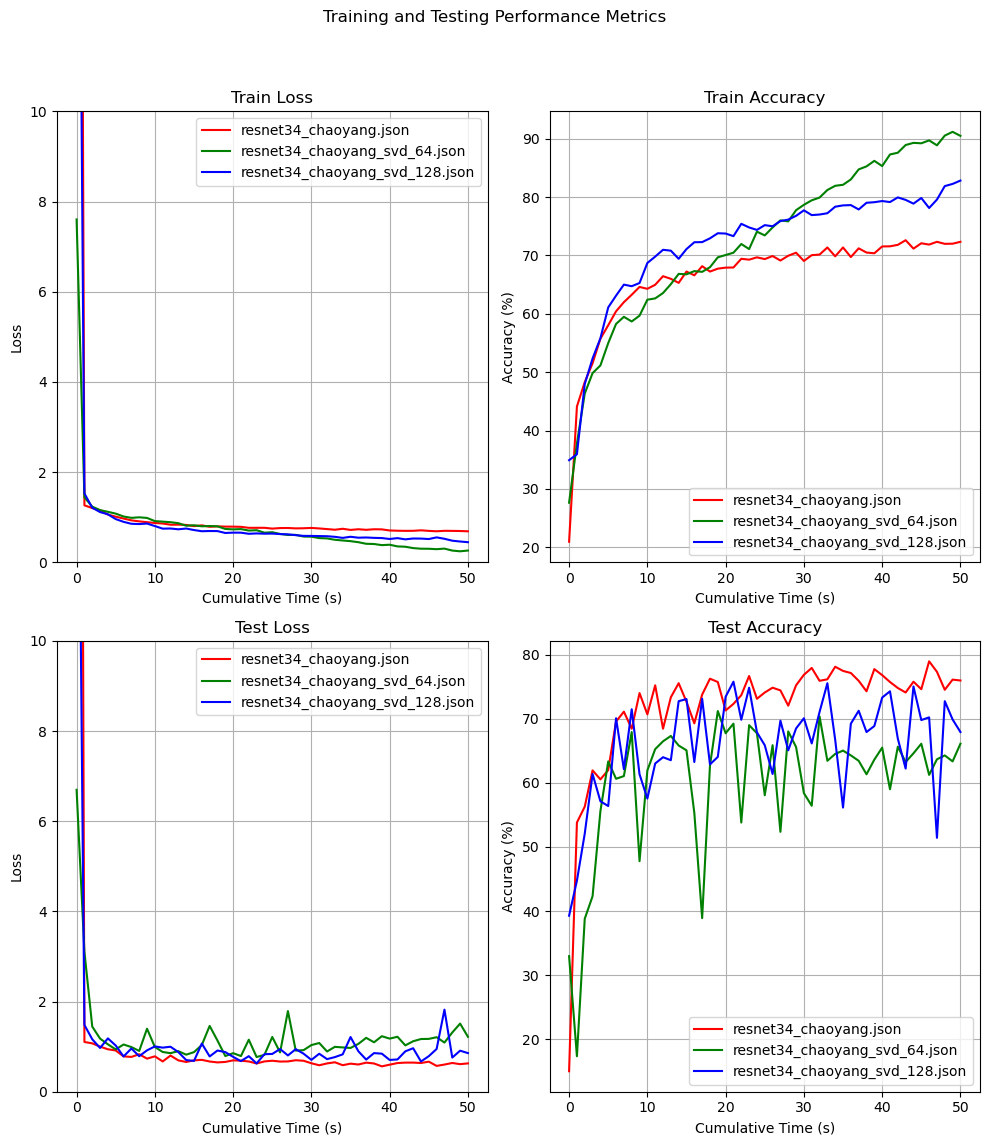

In [20]:
import json
import matplotlib.pyplot as plt

dataset_names = [
    'resnet34_chaoyang.json',
    'resnet34_chaoyang_svd_64.json',
    'resnet34_chaoyang_svd_128.json'
]

fig, axs = plt.subplots(2, 2, figsize=(10, 12))
fig.suptitle('Training and Testing Performance Metrics')

colors = ['red', 'green', 'blue']

def plot_metrics(ax, metric, title, xlabel='Cumulative Time (s)', ylim=None):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(metric)
    ax.grid(True)
    if ylim:
        ax.set_ylim(ylim)

for idx, dataset_name in enumerate(dataset_names):
    with open(dataset_name, 'r') as file:
        stats = json.load(file)   
    epochs = list(range(len(stats['train_loss'])))   
    plot_metrics(axs[0, 0], 'Loss', 'Train Loss', ylim=(0, 10))
    axs[0, 0].plot(epochs, stats['train_loss'], label=dataset_name, color=colors[idx], linestyle='-')
    plot_metrics(axs[0, 1], 'Accuracy (%)', 'Train Accuracy')
    axs[0, 1].plot(epochs, stats['train_accuracy'], label=dataset_name, color=colors[idx], linestyle='-')   
    plot_metrics(axs[1, 0], 'Loss', 'Test Loss', ylim=(0, 10))
    axs[1, 0].plot(epochs, stats['test_loss'], label=dataset_name, color=colors[idx], linestyle='-')
    plot_metrics(axs[1, 1], 'Accuracy (%)', 'Test Accuracy')
    axs[1, 1].plot(epochs, stats['test_accuracy'], label=dataset_name, color=colors[idx], linestyle='-')

for ax in axs.flat:
    ax.legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Plots comparación entre Dataset Chaoyang y SVD Modelo Preentrenado
Se generan gráficos comparativos entre los resultados obtenidos con el dataset original y los datasets reducidos por SVD usando modelos preentrenados.

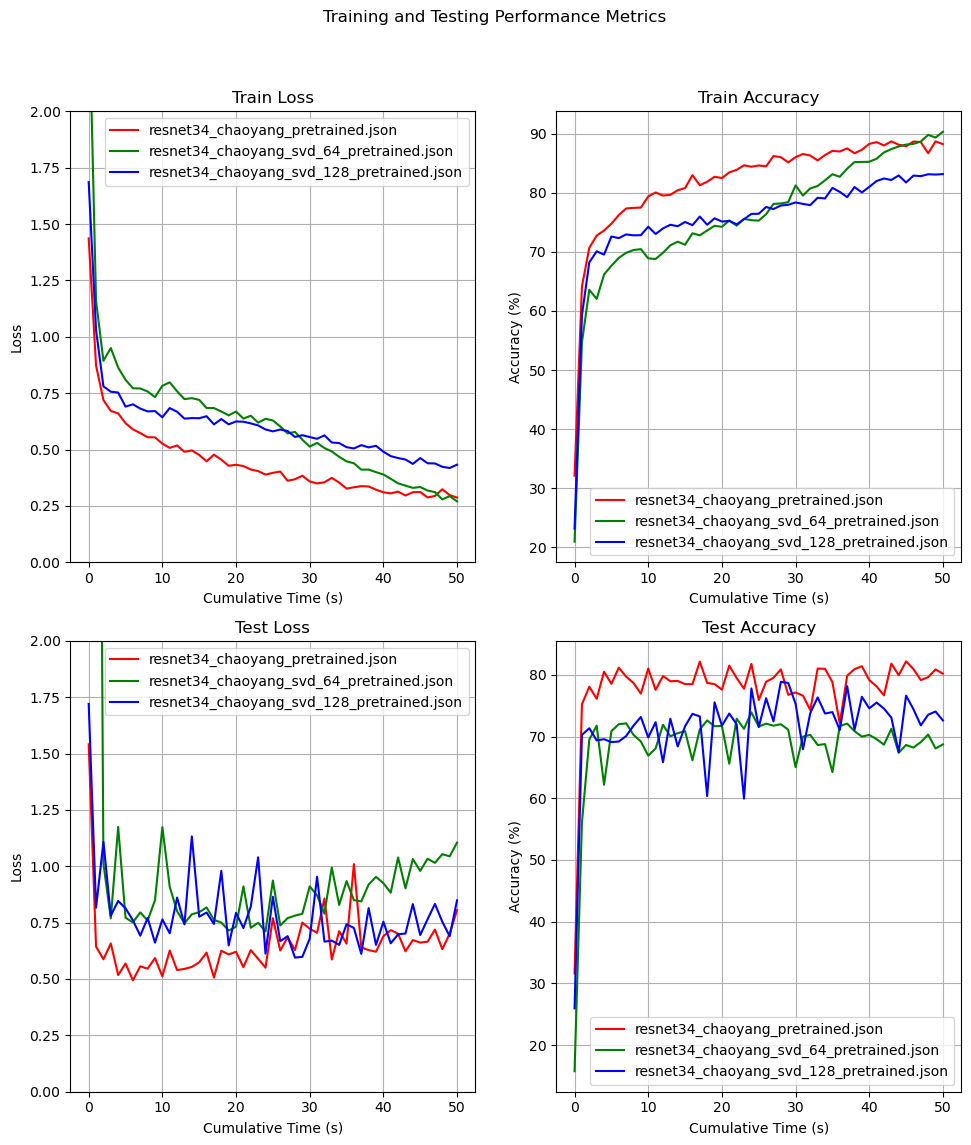

In [24]:
import json
import matplotlib.pyplot as plt

dataset_names = [
    'resnet34_chaoyang_pretrained.json',
    'resnet34_chaoyang_svd_64_pretrained.json',
    'resnet34_chaoyang_svd_128_pretrained.json'
]
fig, axs = plt.subplots(2, 2, figsize=(10, 12))
fig.suptitle('Training and Testing Performance Metrics')
colors = ['red', 'green', 'blue']

for idx, dataset_name in enumerate(dataset_names):
    with open(dataset_name, 'r') as file:
        stats = json.load(file)   
    epochs = list(range(len(stats['train_loss'])))   
    plot_metrics(axs[0, 0], 'Loss', 'Train Loss', ylim=(0, 2))
    axs[0, 0].plot(epochs, stats['train_loss'], label=dataset_name, color=colors[idx], linestyle='-')
    plot_metrics(axs[0, 1], 'Accuracy (%)', 'Train Accuracy')
    axs[0, 1].plot(epochs, stats['train_accuracy'], label=dataset_name, color=colors[idx], linestyle='-')   
    plot_metrics(axs[1, 0], 'Loss', 'Test Loss', ylim=(0, 2))
    axs[1, 0].plot(epochs, stats['test_loss'], label=dataset_name, color=colors[idx], linestyle='-')
    plot_metrics(axs[1, 1], 'Accuracy (%)', 'Test Accuracy')
    axs[1, 1].plot(epochs, stats['test_accuracy'], label=dataset_name, color=colors[idx], linestyle='-')

for ax in axs.flat:
    ax.legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Plots comparación entre Dataset Chaoyang y SVD con ruido
Se generan gráficos comparativos entre los resultados obtenidos con el dataset original con ruido y los datasets reducidos por SVD con ruido.

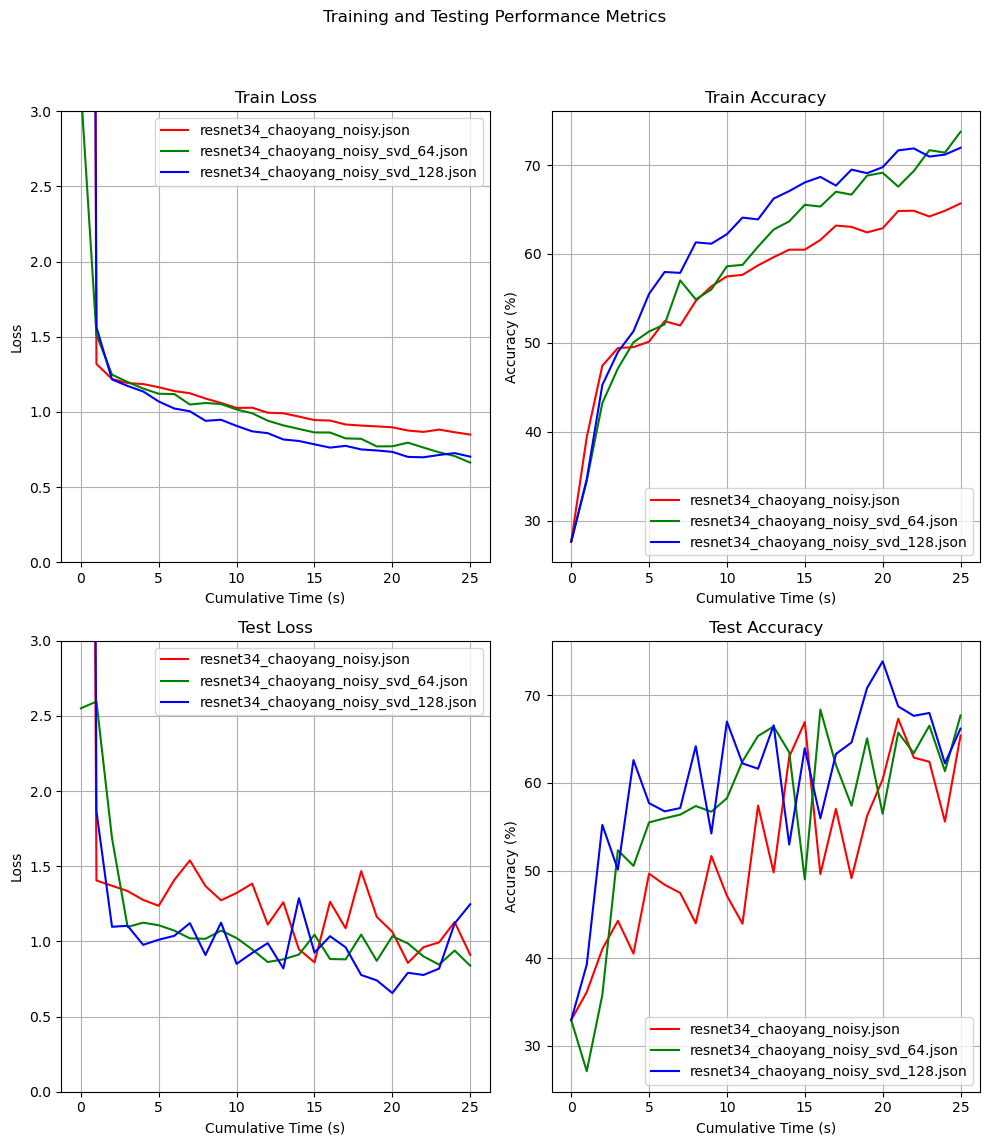

In [31]:
import json
import matplotlib.pyplot as plt

dataset_names = [
    'resnet34_chaoyang_noisy.json',
    'resnet34_chaoyang_noisy_svd_64.json',
    'resnet34_chaoyang_noisy_svd_128.json'
]
fig, axs = plt.subplots(2, 2, figsize=(10, 12))
fig.suptitle('Training and Testing Performance Metrics')
colors = ['red', 'green', 'blue']

for idx, dataset_name in enumerate(dataset_names):
    with open(dataset_name, 'r') as file:
        stats = json.load(file)    
    epochs = list(range(len(stats['train_loss'])))   
    plot_metrics(axs[0, 0], 'Loss', 'Train Loss', ylim=(0, 3))
    axs[0, 0].plot(epochs, stats['train_loss'], label=dataset_name, color=colors[idx], linestyle='-')
    plot_metrics(axs[0, 1], 'Accuracy (%)', 'Train Accuracy')
    axs[0, 1].plot(epochs, stats['train_accuracy'], label=dataset_name, color=colors[idx], linestyle='-')   
    plot_metrics(axs[1, 0], 'Loss', 'Test Loss', ylim=(0, 3))
    axs[1, 0].plot(epochs, stats['test_loss'], label=dataset_name, color=colors[idx], linestyle='-')
    plot_metrics(axs[1, 1], 'Accuracy (%)', 'Test Accuracy')
    axs[1, 1].plot(epochs, stats['test_accuracy'], label=dataset_name, color=colors[idx], linestyle='-')

for ax in axs.flat:
    ax.legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Plots comparación entre Dataset Chaoyang y SVD en el tiempo
Se comparan los tiempos de procesamiento entre el dataset original y los datasets reducidos por SVD.

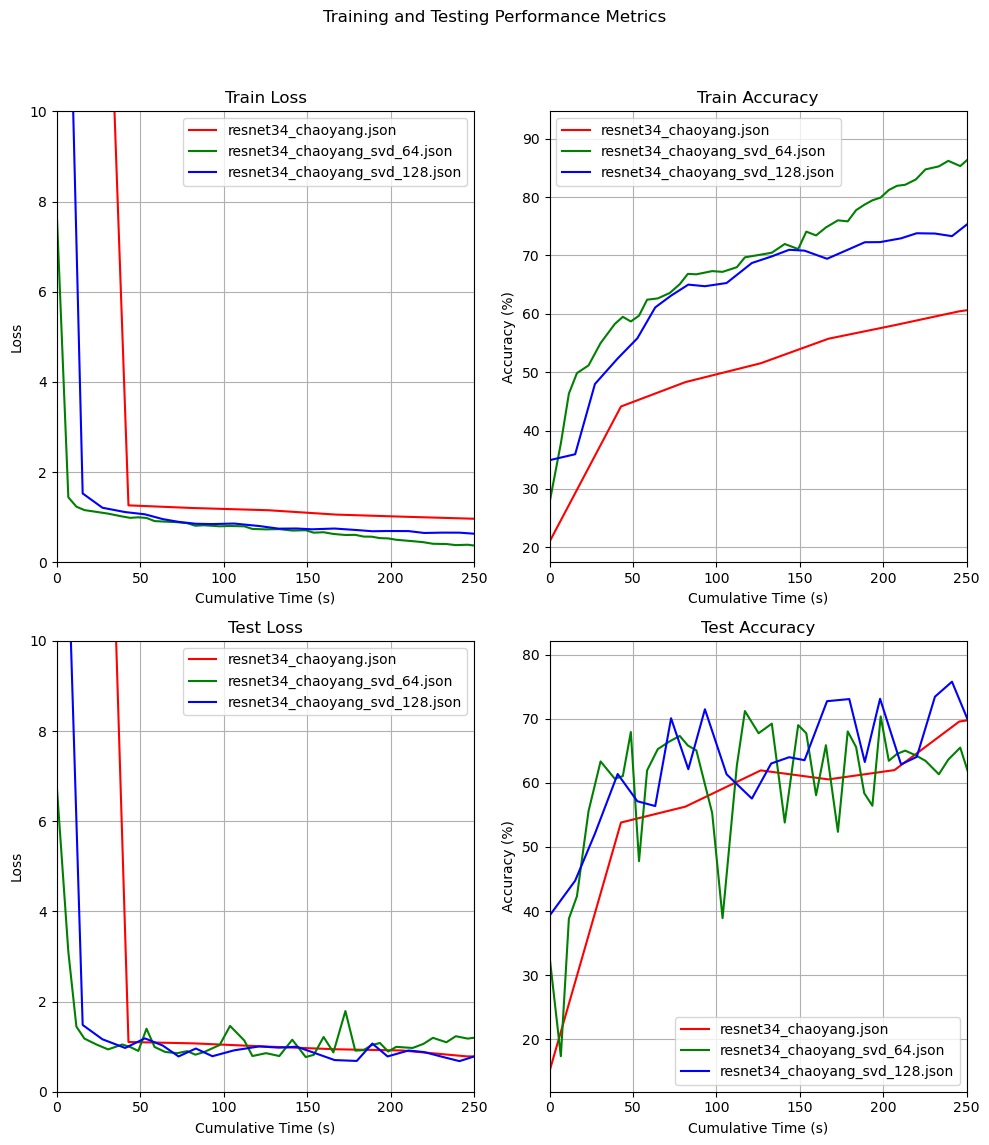

In [21]:
import json
import matplotlib.pyplot as plt
import numpy as np

def calculate_cumulative_time(times):
    cumulative_times = np.cumsum([0] + times)
    return cumulative_times

dataset_names = [
    'resnet34_chaoyang.json',
    'resnet34_chaoyang_svd_64.json',
    'resnet34_chaoyang_svd_128.json'
]
colors = ['red', 'green', 'blue']
fig, axs = plt.subplots(2, 2, figsize=(10, 12))
fig.suptitle('Training and Testing Performance Metrics')

def plot_metrics(ax, metric, title, xlabel='Cumulative Time (s)', xlim=None, ylim=None):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(metric)
    ax.grid(True)
    ax.set_xlim([0, 250])
    if ylim:
        ax.set_ylim(ylim)

for idx, dataset_name in enumerate(dataset_names):
    try:
        with open(dataset_name, 'r') as file:
            stats = json.load(file)
        
        cumulative_time = calculate_cumulative_time(stats['epoch_times'])
        plot_metrics(axs[0, 0], 'Loss', 'Train Loss', ylim=(0, 10))
        axs[0, 0].plot(cumulative_time, stats['train_loss'], label=dataset_name.split('/')[-1], color=colors[idx], linestyle='-')
        plot_metrics(axs[0, 1], 'Accuracy (%)', 'Train Accuracy')
        axs[0, 1].plot(cumulative_time, stats['train_accuracy'], label=dataset_name.split('/')[-1], color=colors[idx], linestyle='-')      
        plot_metrics(axs[1, 0], 'Loss', 'Test Loss', ylim=(0, 10))
        axs[1, 0].plot(cumulative_time, stats['test_loss'], label=dataset_name.split('/')[-1], color=colors[idx], linestyle='-')
        plot_metrics(axs[1, 1], 'Accuracy (%)', 'Test Accuracy')
        axs[1, 1].plot(cumulative_time, stats['test_accuracy'], label=dataset_name.split('/')[-1], color=colors[idx], linestyle='-')
    except Exception as e:
        print(f"Could not process {dataset_name}: {e}")

for ax in axs.flat:
    ax.legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Plots comparación entre Dataset Chaoyang y SVD en el tiempo Modelo Preentrenado
Se comparan los tiempos de procesamiento entre el dataset original y los datasets reducidos por SVD usando modelos preentrenados.

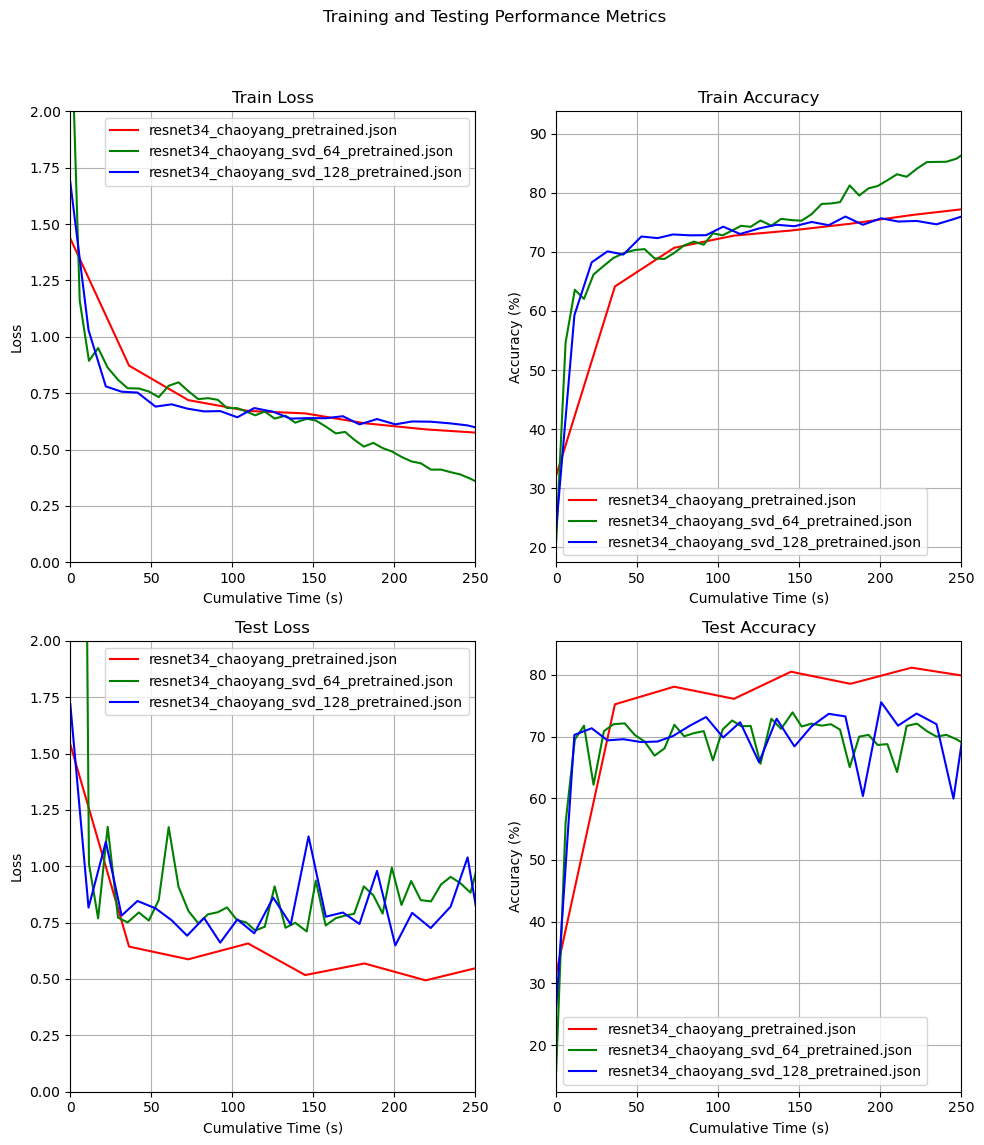

In [26]:
import json
import matplotlib.pyplot as plt
import numpy as np

dataset_names = [
    'resnet34_chaoyang_pretrained.json',
    'resnet34_chaoyang_svd_64_pretrained.json',
    'resnet34_chaoyang_svd_128_pretrained.json'
]
colors = ['red', 'green', 'blue']
fig, axs = plt.subplots(2, 2, figsize=(10, 12))
fig.suptitle('Training and Testing Performance Metrics')

for idx, dataset_name in enumerate(dataset_names):
    try:
        with open(dataset_name, 'r') as file:
            stats = json.load(file)
        cumulative_time = calculate_cumulative_time(stats['epoch_times'])
        plot_metrics(axs[0, 0], 'Loss', 'Train Loss', ylim=(0, 2))
        axs[0, 0].plot(cumulative_time, stats['train_loss'], label=dataset_name.split('/')[-1], color=colors[idx], linestyle='-')
        plot_metrics(axs[0, 1], 'Accuracy (%)', 'Train Accuracy')
        axs[0, 1].plot(cumulative_time, stats['train_accuracy'], label=dataset_name.split('/')[-1], color=colors[idx], linestyle='-')
        plot_metrics(axs[1, 0], 'Loss', 'Test Loss', ylim=(0, 2))
        axs[1, 0].plot(cumulative_time, stats['test_loss'], label=dataset_name.split('/')[-1], color=colors[idx], linestyle='-')
        plot_metrics(axs[1, 1], 'Accuracy (%)', 'Test Accuracy')
        axs[1, 1].plot(cumulative_time, stats['test_accuracy'], label=dataset_name.split('/')[-1], color=colors[idx], linestyle='-')
    except Exception as e:
        print(f"Could not process {dataset_name}: {e}")

for ax in axs.flat:
    ax.legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Plots comparación entre Dataset Chaoyang y SVD con ruido en el tiempo
Se comparan los tiempos de procesamiento entre el dataset original con ruido y los datasets reducidos por SVD con ruido.

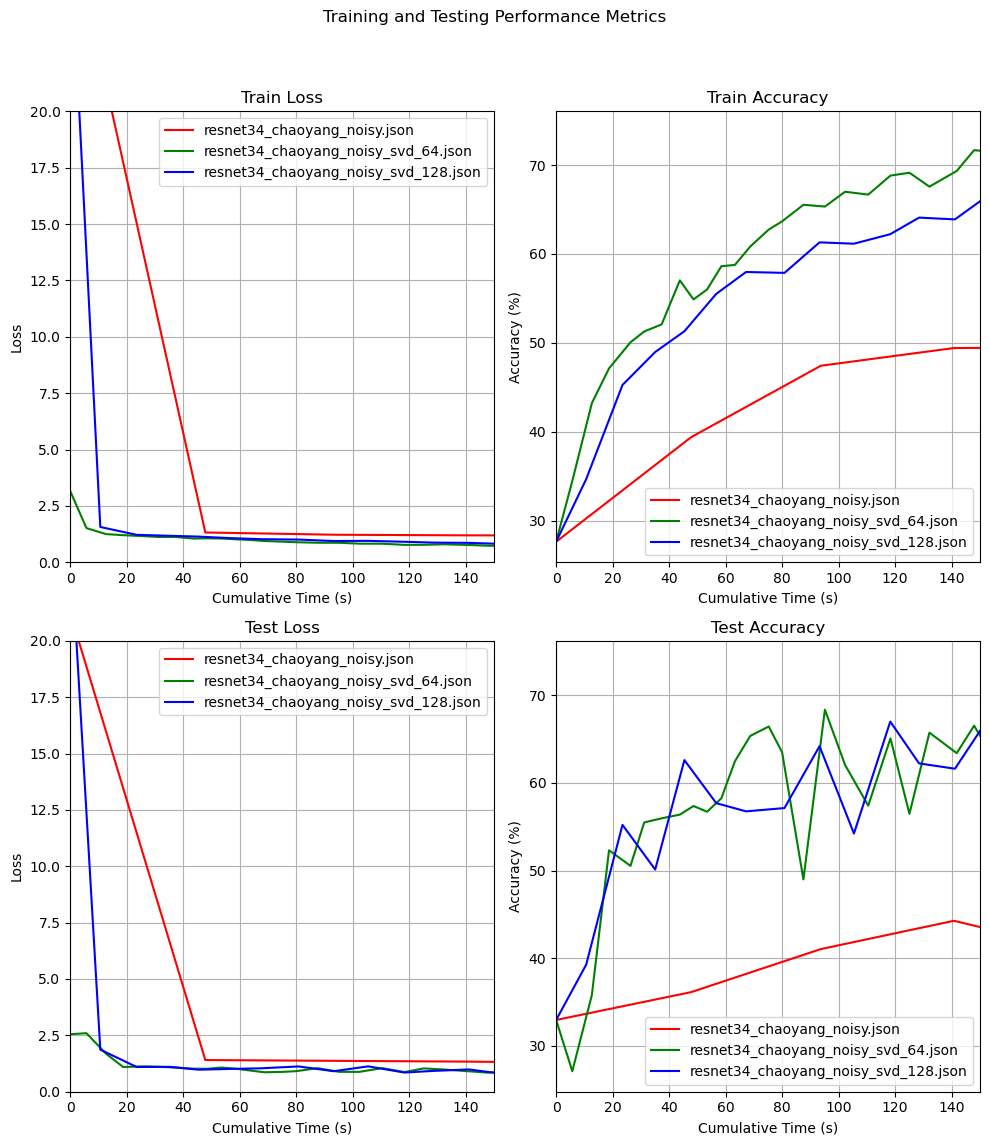

In [36]:
import json
import matplotlib.pyplot as plt
import numpy as np

dataset_names = [
    'resnet34_chaoyang_noisy.json',
    'resnet34_chaoyang_noisy_svd_64.json',
    'resnet34_chaoyang_noisy_svd_128.json'
]
colors = ['red', 'green', 'blue']
fig, axs = plt.subplots(2, 2, figsize=(10, 12))
fig.suptitle('Training and Testing Performance Metrics')

for idx, dataset_name in enumerate(dataset_names):
    try:
        with open(dataset_name, 'r') as file:
            stats = json.load(file)

        cumulative_time = calculate_cumulative_time(stats['epoch_times'])
        plot_metrics(axs[0, 0], 'Loss', 'Train Loss', ylim=(0, 20))
        axs[0, 0].plot(cumulative_time, stats['train_loss'], label=dataset_name.split('/')[-1], color=colors[idx], linestyle='-')
        plot_metrics(axs[0, 1], 'Accuracy (%)', 'Train Accuracy')
        axs[0, 1].plot(cumulative_time, stats['train_accuracy'], label=dataset_name.split('/')[-1], color=colors[idx], linestyle='-')
        plot_metrics(axs[1, 0], 'Loss', 'Test Loss', ylim=(0, 20))
        axs[1, 0].plot(cumulative_time, stats['test_loss'], label=dataset_name.split('/')[-1], color=colors[idx], linestyle='-')
        plot_metrics(axs[1, 1], 'Accuracy (%)', 'Test Accuracy')
        axs[1, 1].plot(cumulative_time, stats['test_accuracy'], label=dataset_name.split('/')[-1], color=colors[idx], linestyle='-')
    except Exception as e:
        print(f"Could not process {dataset_name}: {e}")


for ax in axs.flat:
    ax.legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Tablas
Se generan tablas comparativas de los resultados obtenidos en los distintos casos de entrenamiento.

In [45]:
import pandas as pd
import json
import os
import numpy as np

dataset_names_list = [
    [
        'resnet34_chaoyang.json',
        'resnet34_chaoyang_svd_64.json',
        'resnet34_chaoyang_svd_128.json'
    ],
    [
        'resnet34_chaoyang_pretrained.json',
        'resnet34_chaoyang_svd_64_pretrained.json',
        'resnet34_chaoyang_svd_128_pretrained.json'
    ],
    [
        'resnet34_chaoyang_noisy.json',
        'resnet34_chaoyang_noisy_svd_64.json',
        'resnet34_chaoyang_noisy_svd_128.json'
    ]
]

labels = [
    "Chaoyang",
    "Chaoyang SVD 64",
    "Chaoyang SVD 128",
    "Chaoyang Pretrained",
    "Chaoyang Pretrained SVD 64",
    "Chaoyang Pretrained SVD 128",
    "Chaoyang Noisy",
    "Chaoyang Noisy SVD 64",
    "Chaoyang Noisy SVD 128"
]

def read_json_file(file_name):
    with open(file_name, 'r') as f:
        return json.load(f)

def calculate_metrics(data):
    max_accuracy = max(data['test_accuracy'])
    min_loss = min(data['test_loss'])
    avg_epoch_time = np.mean(data['epoch_times'])
    return max_accuracy, min_loss, avg_epoch_time

results = {}

for i, dataset_names in enumerate(dataset_names_list):
    for j, file_name in enumerate(dataset_names):
        data = read_json_file(file_name)
        model_name = labels[i * len(dataset_names) + j]
        max_accuracy, min_loss, avg_epoch_time = calculate_metrics(data)
        results[model_name] = {
            'Max Accuracy': max_accuracy,
            'Min Loss': min_loss,
            'Epoch Time': avg_epoch_time
        }

df = pd.DataFrame(results).transpose()
styles = [
    {'selector': 'tr:nth-of-type(3n+1)', 'props': [('border-top', '3px solid black')]}
]

df = df.style.set_table_styles(styles)
df


,Max Accuracy,Min Loss,Epoch Time
Chaoyang,78.962132,0.562491,39.198804
Chaoyang SVD 64,71.201496,0.769223,6.401885
Chaoyang SVD 128,75.783076,0.627005,11.231928
Chaoyang Pretrained,82.187938,0.493976,37.943489
Chaoyang Pretrained SVD 64,73.913043,0.711033,6.011956
Chaoyang Pretrained SVD 128,78.868630,0.594952,10.747189
Chaoyang Noisy,67.321178,0.857264,44.963607
Chaoyang Noisy SVD 64,68.349696,0.838340,6.601620
Chaoyang Noisy SVD 128,73.866293,0.656310,11.622514


# Conclusiones

Se puede observar que para todos los datasets procesados con SVD, el tiempo de procesamiento por época es mucho menor en comparación con los datasets sin SVD, independientemente de la resolución. Aunque los datasets con SVD muestran una menor precisión máxima en comparación con los datasets originales, el tiempo de procesamiento significativamente reducido puede ser una ventaja en escenarios donde la rapidez es crucial.

## Tiempo de Procesamiento

Para todos los datasets procesados con SVD, el tiempo de procesamiento por época es considerablemente menor en comparación con los datasets sin SVD. Este patrón se repite en los modelos preentrenados y en los datasets con ruido, donde los tiempos de procesamiento para los modelos con SVD son consistentemente más bajos. Lo que comprueba que la reducción de dimensionalidad mediante SVD es una técnica efectiva para acelerar el entrenamiento de modelos.

## Caso Sin Ruido

En cuanto a la precisión, los datasets originales y preentrenados sin SVD tienen una mayor precisión para los casos sin ruido. Los modelos entrenados con el dataset Chaoyang original alcanzan una precisión máxima más alta en comparación con los modelos entrenados con datasets reducidos mediante SVD. Sin embargo, los modelos con SVD 64 y SVD 128 siguen siendo competitivos, aunque con una precisión ligeramente inferior, particularmente en los plots que consideran el tiempo.

## Caso Con Ruido

Sin embargo, el dataset original muestra el peor rendimiento en términos de precisión cuando se añade ruido. Los datasets procesados con SVD muestran una mejor resistencia al ruido. Esto sugiere que, aunque los modelos con datasets reducidos mediante SVD tienen una menor precisión en escenarios sin ruido, son más robustos al ruido, especialmente cuando se consideran las versiones reducidas a 128x128 píxeles. En resumen, la reducción de dimensionalidad mediante SVD ofrece una significativa mejora en el tiempo de procesamiento y una mayor resistencia al ruido.

## Trabajos Futuros

Para trabajos futuros, se puede considerar la aplicación de estas técnicas de reducción de dimensionalidad y adición de ruido en datasets más complejos, como en imágenes de alta resolución. Además, se podria explorar el uso de modelos más avanzados y complejos, como los transformers, que aunque tienen un tiempo de procesamiento mayor, podrían beneficiarse significativamente de la reducción de dimensionalidad para mejorar la eficiencia sin comprometer el rendimiento.